# Test Your Algorithm

## Instructions
1. From the **Pulse Rate Algorithm** Notebook you can do one of the following:
   - Copy over all the **Code** section to the following Code block.
   - Download as a Python (`.py`) and copy the code to the following Code block.
2. In the bottom right, click the <span style="color:blue">Test Run</span> button. 

### Didn't Pass
If your code didn't pass the test, go back to the previous Concept or to your local setup and continue iterating on your algorithm and try to bring your training error down before testing again.

### Pass
If your code passes the test, complete the following! You **must** include a screenshot of your code and the Test being **Passed**. Here is what the starter filler code looks like when the test is run and should be similar. A passed test will include in the notebook a green outline plus a box with **Test passed:** and in the Results bar at the bottom the progress bar will be at 100% plus a checkmark with **All cells passed**.
![Example](example.png)

1. Take a screenshot of your code passing the test, make sure it is in the format `.png`. If not a `.png` image, you will have to edit the Markdown render the image after Step 3. Here is an example of what the `passed.png` would look like 
2. Upload the screenshot to the same folder or directory as this jupyter notebook.
3. Rename the screenshot to `passed.png` and it should show up below.
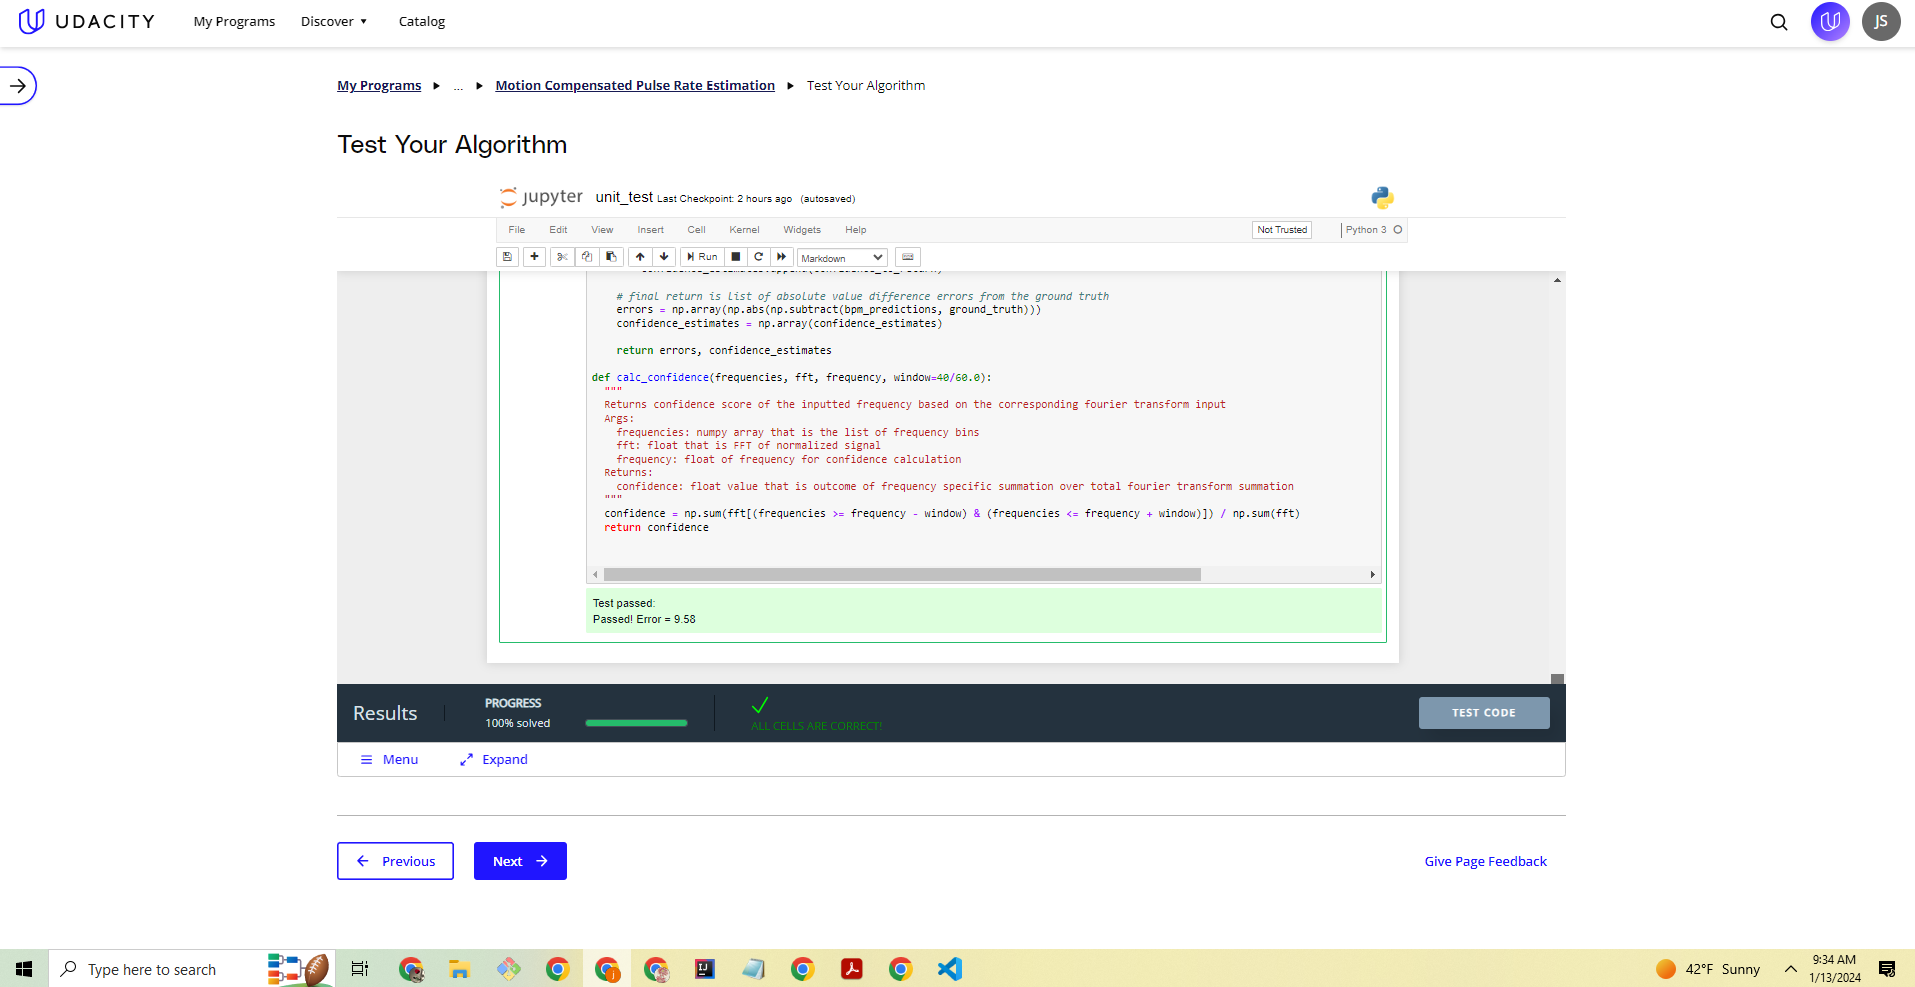
4. Download this jupyter notebook as a `.pdf` file. 
5. Continue to Part 2 of the Project. 

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.io
from scipy import signal
from scipy.signal import butter, lfilter
def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability.

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def butter_bandpass_filter(signal, fs, pass_band=(40/60.0, 240/60.0)):
  """
  Bandpass given numpy array singal between 40 Hz and 240 Hz by default
  Args:
    signal: numpy array. ppm/acc signal
    fs: int. Sampling frequency in Hz
    pass_band: tuple. filter band width set to between 40BPM(40/60 Hz) and 240BPM(40Hz) by default
    order: int. order of butter band pass
  Returns:
    filtered_signal: ndarray of bandpassed signal
  """
  numerator_vector, denominator_vector = sp.signal.butter(5, pass_band, btype='bandpass', fs=fs)
  return scipy.signal.filtfilt(numerator_vector, denominator_vector, signal)

def RunPulseRateAlgorithm(data_fl, ref_fl, fs = 125, window_length=8, window_shift=2, min_bandpass=(40/60.0), max_bandpass=(240/60.0)):
    """
    Returns the absolute error between the algorithm based bpm predictions from the inputed data file and the reference file
    alongside a list of corresponding confidence scores
    Args:
        data_fl: str filepath to DATA file
        ref_fl: str filepath to REF file 
    Return:
        errors: numpy array list of absolute difference error between the inputted reference file and predicted heart rate values
        confidence: numpy array list of the corresponding confidence scores for the predicted heart rate values 
    """
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # Bandpass filter the ppg data
    filtered_ppg = butter_bandpass_filter(ppg, fs)
    
    # filter the x,y,and z component of the accelerometer data 
    filtered_accx = butter_bandpass_filter(accx, fs)
    filtered_accy = butter_bandpass_filter(accy, fs)
    filtered_accz = butter_bandpass_filter(accz, fs)

    filtered_acc = np.sqrt(filtered_accx**2 + filtered_accy**2 + filtered_accz**2)

    ground_truth = scipy.io.loadmat(ref_fl)['BPM0'].reshape(-1)

    # use shifting window technique to calculate predictions, confidence and error 
    window_length = window_length * fs
    window_shift = window_shift * fs

    # bpm predictions and confidence estimates empty lists 
    bpm_predictions = []
    confidence_estimates = []

    #shifting window calculations of 8 filtered_ppg with 6 second overlaps
    for shift_start_index in range(0, len(ppg) - window_length + 1, window_shift):
        # extracting corresponding ppg and accelerometer data windows(8 seconds long each)
        ppg_window = filtered_ppg[shift_start_index:shift_start_index+window_length]
        acc_window = filtered_acc[shift_start_index:shift_start_index+window_length]
        accx_window = filtered_accx[shift_start_index:shift_start_index+window_length]
        accy_window = filtered_accy[shift_start_index:shift_start_index+window_length]
        accz_window = filtered_accz[shift_start_index:shift_start_index+window_length]
        # fourier transform the window
        ppg_window_length = len(ppg_window) 
        acc_window_length = len(acc_window) 

        # extracting magnitude of pgg and accelerometer data frequencies and fourier transform of the window 
        ppg_frequencies, ppg_fast_fourier_transform = np.abs(np.fft.rfftfreq(ppg_window_length, 1/fs)), np.abs(np.fft.rfft(ppg_window, ppg_window_length))

        acc_frequencies, acc_fast_fourier_transform = np.abs(np.fft.rfftfreq(acc_window_length, 1/fs)), np.abs(np.fft.rfft(acc_window, acc_window_length))
        accx_frequencies, accx_fast_fourier_transform = np.abs(np.fft.rfftfreq(acc_window_length, 1/fs)), np.abs(np.fft.rfft(accx_window, acc_window_length))
        accy_frequencies, accy_fast_fourier_transform = np.abs(np.fft.rfftfreq(acc_window_length, 1/fs)), np.abs(np.fft.rfft(accy_window, acc_window_length))
        accz_frequencies, accz_fast_fourier_transform = np.abs(np.fft.rfftfreq(acc_window_length, 1/fs)), np.abs(np.fft.rfft(accz_window, acc_window_length))

        
        # clipping all unwanted frequencies below and above the min and max bandpasses for the ppg data
        ppg_fast_fourier_transform[(ppg_frequencies <= min_bandpass) | (ppg_frequencies >= max_bandpass)] = 0.0
        # clipping all unwanted frequencies below and above the min and max bandpasses for the acc data
        acc_fast_fourier_transform[(acc_frequencies <= min_bandpass) | (acc_frequencies >= max_bandpass)] = 0.0
        # clipping all unwanted frequencies below and above the min and max bandpasses for the acc x,y, and z components individually
        accx_fast_fourier_transform[(accx_frequencies <= min_bandpass) | (accx_frequencies >= max_bandpass)] = 0.0
        accy_fast_fourier_transform[(accy_frequencies <= min_bandpass) | (accy_frequencies >= max_bandpass)] = 0.0
        accz_fast_fourier_transform[(accz_frequencies <= min_bandpass) | (accz_frequencies >= max_bandpass)] = 0.0

        #pick most prominent ffq frequency 
        ppg_frequency = ppg_frequencies[np.argmax(ppg_fast_fourier_transform, axis=0)]
        acc_frequency = acc_frequencies[np.argmax(acc_fast_fourier_transform, axis=0)]

        # confidence calculation from fourier transform inputs
        ppg_confidence = calc_confidence(ppg_frequencies, ppg_fast_fourier_transform, ppg_frequency)

        # setting the frequency to return as the ppg frequency right now but can change based on relative ppg/acc frequencies
        frequency_to_return = ppg_frequency
        confidence_to_return = ppg_confidence
        # if the accelerometer frequency is too close to the ppg frequency then first check for if the 
        # second biggest frequency is a viable option as suggested by udacity project overview before iteration                    
        if (acc_frequency - ppg_frequency == 0.0):
            next_best_frequency = ppg_frequencies[np.argsort(ppg_fast_fourier_transform, axis=0)[-2]]  
            next_best_frequency_confidence = calc_confidence(ppg_frequencies, ppg_fast_fourier_transform, next_best_frequency)
            frequency_to_return, confidence_to_return = next_best_frequency, next_best_frequency_confidence
        else:
            # go down the fourier transform along frequency magnitudes
            
            for i in range(0, len(ppg_fast_fourier_transform)):
                next_best_frequency = ppg_frequencies[np.argsort(ppg_fast_fourier_transform, axis=0)[-(i+1)]]
                corresponding_accelerometer_frequency = acc_frequencies[np.argsort(acc_fast_fourier_transform, axis=0)[-(i+1)]]
                next_best_frequency_confidence = calc_confidence(ppg_frequencies, ppg_fast_fourier_transform, next_best_frequency)

                # replacing the return frequency and confidence to that of the second biggest frequency if its confidence 
                # is higher and isn't affected by arm swing cadence frequency, repeating iteration process through all frequencies
                if ((next_best_frequency_confidence - confidence_to_return >= 0.2) & (np.abs(corresponding_accelerometer_frequency - next_best_frequency) > 0.15)):
                    frequency_to_return, confidence_to_return = next_best_frequency, next_best_frequency_confidence



        bpm_predictions.append(frequency_to_return * 60) # multiplying by 60 because ground truth values are in bpm
        confidence_estimates.append(confidence_to_return)

    # final return is list of absolute value difference errors from the ground truth 
    errors = np.array(np.abs(np.subtract(bpm_predictions, ground_truth)))
    confidence_estimates = np.array(confidence_estimates)
    
    return errors, confidence_estimates

def calc_confidence(frequencies, fft, frequency, window=40/60.0):
  """
  Returns confidence score of the inputted frequency based on the corresponding fourier transform input
  Args:
    frequencies: numpy array that is the list of frequency bins
    fft: float that is FFT of normalized signal
    frequency: float of frequency for confidence calculation
  Returns:
    confidence: float value that is outcome of frequency specific summation over total fourier transform summation
  """
  confidence = np.sum(fft[(frequencies >= frequency - window) & (frequencies <= frequency + window)]) / np.sum(fft)
  return confidence

